## Confirm runtime settings

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Sep 30 14:21:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Main Notebook

In [72]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as colors

import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from tqdm import tqdm
import time

# science plots requirements
!apt-get update
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install SciencePlots
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')

device = 'cuda' if torch.cuda.is_available() else 'cpu'


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [68.5 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://developer.download.nvi

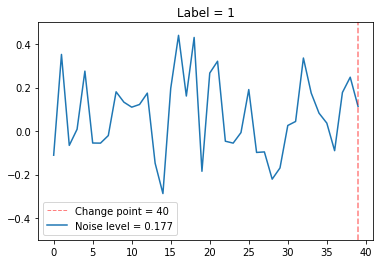

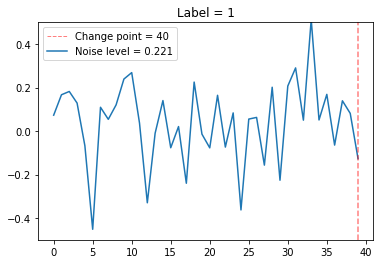

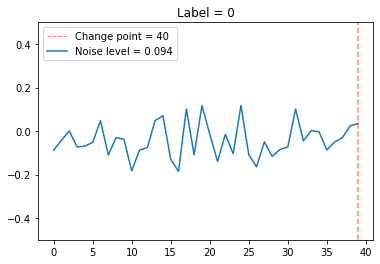

In [4]:
# data generation

def generate_ns_batch(batch_size=20, seq_len=40, lower=0.1, upper=0.1, 
                      margin=0.1, min_change_point=15, max_change_point=25):
    """
    Generates a batch of data described as follows:
    Each sequence is either of class 1 or 0 with just a single input sequence.
    Up until time T all elements of a sequence are 0 + K + noise, where K = + 0.2 for 
    class 1 and - 0.2 for class 0. 
    Then after the T'th element of the sequence, all vaules are just 0 + noise (uninformative).
    The amount of noise and value of T determine how challenging a sequnece is. 
    
    Args:
        batch size (int): size of batch (must be even).
        seq_len (int): length of individual seqences.
        lower (float): lower bound for uniform distribution on the value of the stadard deviation
            of the gaussian noise for a given sequence.
        upper (float): upper bound for uniform distribution on the value of the stadard deviation
            of the gaussian noise for a given sequence.
        margin (float): the value of K in the above description.
        min_change_point (int): T is uniformly distributed ~ (min_change_point, max_change_point).
        max_change_point (int): T is uniformly distributed ~ (min_change_point, max_change_point).
        
    Returns:
        x_vals (Torch Tensor): Tensor of data of shape (batch_size, seq_len).
        y_vals (Torch Tensor): Corresponding labels of size (batch_size).
        T (Torch Tensor): Tensor of values of T for each sequence in the batch of size (batch_size).
            These are the indexes of the first element in the seq that contain no signal (i.e the
            optimal idx for spiking after).
        std_vec (Torch Tensor): Tensor of values of the the standard deviation of the noise for 
            each sequence in the batch of size (batch_size).
    
    """
    # generate labels
    y_vals = torch.tensor([1.,0.], device=device).repeat(int(batch_size/2))
    # make tensor of indexes for t
    T = torch.randint(low=min_change_point, high=max_change_point, size=(batch_size,), 
                      device=device)
    repeats = torch.empty(2*batch_size, dtype=torch.long, device=device)
    repeats[::2] = T
    repeats[1::2] = seq_len - T
    # make a 2d tensor based on these indexes
    vals = torch.tensor([1,0], device=device).tile(batch_size)
    data = torch.repeat_interleave(vals, repeats).reshape(batch_size, seq_len)
    # convert 1's to margin or -margin based on class
    margin_vec = torch.tensor([[margin, -margin]], device=device).tile(int(batch_size/2))
    data = data * margin_vec.T
    # finally add iid gaussian noise to all elements
    normal_mat = torch.randn((batch_size, seq_len), device=device)
    std_vec = (lower - upper) * torch.rand((batch_size,1), device=device) + upper
    noise = std_vec * normal_mat
    x_vals = data + noise
    # randomly shuffle the data 
    idxs = torch.randperm(batch_size)
    return x_vals[idxs], y_vals[idxs], T[idxs], std_vec[idxs]

X, y, T, std_vec = generate_ns_batch(min_change_point=40, max_change_point=41, 
                                     seq_len=40, lower=0.05, upper=0.25, margin=0.05)

# plot a few examples
for i in range(3):
    plt.title(f'Label = {int(y[i].item())}')
    plt.plot(X[i].cpu().numpy())
    legend_elements = [Line2D([0], [0], color='r', linestyle='--', lw=1, alpha = 0.5,
                              label=f'Change point = {T[i].item()}'),
                   Line2D([0], [0], color='#1f77b4', label=f'Noise level = {std_vec[i].item():.3f}')]
    plt.axvline(x=T[i].item() - 1, linestyle='--', c='red', alpha = 0.5)
    plt.legend(handles=legend_elements)
    plt.ylim(-0.5, 0.5)
    plt.show()

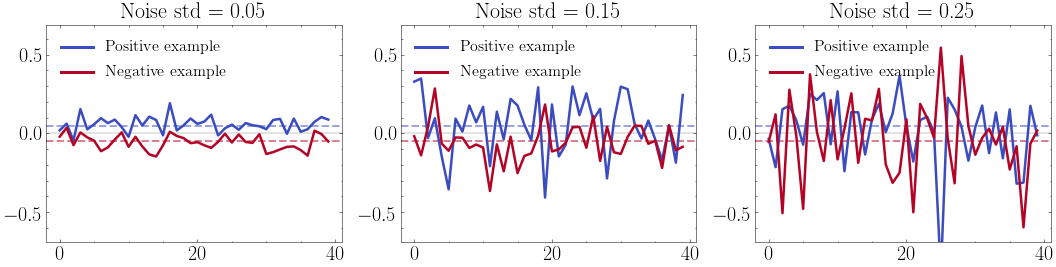

In [102]:
# SAMPLE DATA PLOT

# parameters 
title_text_size = 22
tick_label_size = 20
legend_size = 16
xmin = 0.
xmax=1

# setup
torch.manual_seed(0)
cmap = cm.get_cmap('coolwarm')

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18,4))

# first plot
noise_level = 0.05
X, y, T, std_vec = generate_ns_batch(min_change_point=40, max_change_point=41, 
                                     seq_len=40, lower=noise_level, upper=noise_level, margin=0.05)
ax0.set_title(f'Noise std = {noise_level}', size=title_text_size)
ax0.plot(X[i].cpu().numpy(), c=cmap(0.), zorder=1, linewidth=2.5)
ax0.plot(X[1].cpu().numpy(), c=cmap(1.), zorder=1, linewidth=2.5)
legend_elements = [Line2D([0], [0], color=cmap(0.), label=f'Positive example', linewidth=3),
                   Line2D([0], [0], color=cmap(1.), label=f'Negative example', linewidth=3)]
ax0.axhline(y=0.05, xmin=xmin, xmax=xmax, c=cmap(0.), alpha=0.5, linestyle='--', zorder=0, linewidth=2)
ax0.axhline(y=-0.05, xmin=xmin, xmax=xmax, c=cmap(1.), alpha=0.5, linestyle='--', zorder=0, linewidth=2)
ax0.axhline(y=0.0, xmin=xmin, xmax=xmax, c=cmap(0.5), alpha=0.8, linestyle='-', zorder=0, linewidth=2)
ax0.legend(handles=legend_elements, loc='upper left', prop={'size': legend_size})
ax0.set_ylim([-0.69, 0.69])
ax0.tick_params(axis='both', labelsize=tick_label_size)

# second plot
noise_level = 0.15
X, y, T, std_vec = generate_ns_batch(min_change_point=40, max_change_point=41, 
                                     seq_len=40, lower=noise_level, upper=noise_level, margin=0.05)
ax1.set_title(f'Noise std = {noise_level}', size=title_text_size)
ax1.plot(X[3].cpu().numpy(), c=cmap(0.), zorder=1, linewidth=2.5)
ax1.plot(X[1].cpu().numpy(), c=cmap(1.), zorder=1, linewidth=2.5)
legend_elements = [Line2D([0], [0], color=cmap(0.), label=f'Positive example', linewidth=3),
                   Line2D([0], [0], color=cmap(1.), label=f'Negative example', linewidth=3)]
ax1.axhline(y=0.05, xmin=xmin, xmax=xmax, c=cmap(0.), alpha=0.5, linestyle='--', zorder=0, linewidth=2)
ax1.axhline(y=-0.05, xmin=xmin, xmax=xmax, c=cmap(1.), alpha=0.5, linestyle='--', zorder=0, linewidth=2)
ax1.axhline(y=0.0, xmin=xmin, xmax=xmax, c=cmap(0.5), alpha=0.8, linestyle='-', zorder=0, linewidth=2)
ax1.legend(handles=legend_elements, loc='upper left', prop={'size': legend_size})
ax1.set_ylim([-0.69, 0.69])
ax1.tick_params(axis='both', labelsize=tick_label_size)

# third plot
noise_level = 0.25
X, y, T, std_vec = generate_ns_batch(min_change_point=40, max_change_point=41, 
                                     seq_len=40, lower=noise_level, upper=noise_level, margin=0.05)
ax2.set_title(f'Noise std = {noise_level}', size=title_text_size)
ax2.plot(X[1].cpu().numpy(), c=cmap(0.), zorder=1, linewidth=2.5)
ax2.plot(X[2].cpu().numpy(), c=cmap(1.), zorder=1, linewidth=2.5)
legend_elements = [Line2D([0], [0], color=cmap(0.), label=f'Positive example', linewidth=3),
                   Line2D([0], [0], color=cmap(1.), label=f'Negative example', linewidth=3)]
ax2.axhline(y=0.05, xmin=xmin, xmax=xmax, c=cmap(0.), alpha=0.5, linestyle='--', zorder=0, linewidth=2)
ax2.axhline(y=-0.05, xmin=xmin, xmax=xmax, c=cmap(1.), alpha=0.5, linestyle='--', zorder=0, linewidth=2)
ax2.axhline(y=0.0, xmin=xmin, xmax=xmax, c=cmap(0.5), alpha=0.8, linestyle='-', zorder=0, linewidth=2)

ax2.legend(handles=legend_elements, loc='upper left', prop={'size': legend_size})
ax2.set_ylim([-0.69, 0.69])
ax2.tick_params(axis='both', labelsize=tick_label_size)

plt.savefig('sig_vs_noise.svg', format='svg', dpi = 1200)
plt.show()

In [103]:
torch.manual_seed(3)

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, nhid, f_bias=True):
        super(LSTM, self).__init__()
        self.nhid = nhid
        self.lstm = nn.LSTM(input_size, nhid, batch_first=True)
        self.linear = nn.Linear(nhid, output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        h0 = torch.zeros(1, inputs.size(0), self.nhid).to(device) 
        c0 = torch.zeros(1, inputs.size(0), self.nhid).to(device)
        y1, _ = self.lstm(inputs, (h0, c0))  # input should have dimension (B, S, I)
        o = self.linear(y1)
        return o

In [104]:
# helper functions 

def gather_spiking_preds(spikes, out, last_idx=39):
      """
      Gather predictions based on first spike or final output if no spike
      occurs. 

      Args:
          spikes (torch tensor): Tensor of binary spikes.
          out (torch tensor): Tensor of all model predictions.
          y (torch tensor)
          last_idx (int): Index of the final element in the sequence.

      Returns:
          Torch tensor: Outputs at these spiking values.
          Int: Number of observations in which no spike occured.
      """
      first_spike_idx = torch.argmax(spikes, dim=1, keepdim=True)
      no_spike_count = torch.sum(first_spike_idx == 0).item()
      # replace no spike with last idx for prediction
      first_spike_idx[first_spike_idx == 0] = last_idx
      preds = torch.gather(out, 1, first_spike_idx)  
      preds = preds.squeeze(-1).squeeze(-1)
      return preds, no_spike_count



In [105]:
# calculate mean spike time for both classes
def calc_mean_spike_times(spikes, y):
    first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
    class_0_spikes = first_spike_idx[(first_spike_idx > 0) * (y == 0)]
    class_1_spikes = first_spike_idx[(first_spike_idx > 0) * (y == 1)]
    class_0_mean = class_0_spikes.sum()/class_0_spikes.size(0)
    class_1_mean = class_1_spikes.sum()/class_1_spikes.size(0)
    return class_0_mean.item(), class_1_mean.item()

# calculate average lag between optimal spike and observed spike
def calc_mean_lag(spikes, preds, y, opt_idx):
    first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
    preds = torch.round(preds)
    spiking_obs = (y == preds) * (first_spike_idx != 0) 
    lags = first_spike_idx[spiking_obs] - opt_idx[spiking_obs]
    early_spikes = torch.sum(lags < 0).item()
    lags = lags[lags >= 0]  # remove early spikes
    mean_lag = (lags.sum()/lags.size(0)).item()
    return mean_lag, early_spikes


In [175]:
model = LSTM(1, 1, 125)
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = torch.nn.BCELoss()
s = nn.Sigmoid()

NUM_TRAIN_EXAMPLES = 4*500000
BATCH_SIZE = 128
VALIDATION_SIZE = 2000
VALIDATION_FREQ = 50
PATH = '/model_weights'

best_spiking_acc = 0
loss_ls = []
spiking_acc_ls = []
custom_loss_ls = []
class_0_spike_times_ls = []
class_1_spike_times_ls = []
mean_lag_ls = []
early_spike_count_ls = []
num_batches = int(np.ceil(NUM_TRAIN_EXAMPLES/BATCH_SIZE))
seq_lens = torch.repeat_interleave(torch.tensor([39]), BATCH_SIZE).unsqueeze(-1).unsqueeze(-1).to(device)
print('################## TRAINING ##################')
print('Training {} examples in batches of size {}'.format(NUM_TRAIN_EXAMPLES, BATCH_SIZE))
print(f'resulting in {num_batches} batches')
print('##############################################\n')

time.sleep(0.2)
for i in tqdm(range(num_batches)):
    ######################## TRAIN A BATCH ########################
    # generate some training data 
    X, y, _, _ = generate_ns_batch(batch_size=BATCH_SIZE, min_change_point=40,
                                   max_change_point=41, seq_len=40, lower=0.05,
                                   upper=0.25, margin=0.05)
    X.unsqueeze_(-1)
    
    # learn through network
    model.train()
    optimiser.zero_grad()
    out = model(X)
    out = s(out)
    
    # grab indixes of first spikes
    # with torch.no_grad():
    #     spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
    #     first_spike_idx = torch.argmax(spikes, dim=1, keepdim=True)
    #     first_spike_idx[first_spike_idx == 0] = 39  # replace no spike with last idx
        
    # preds = torch.gather(out, 1, first_spike_idx) 
    preds = torch.gather(out, 1, seq_lens)   
    preds = preds.squeeze(-1).squeeze(-1)
    
    loss = criterion(preds, y)
    loss_ls.append(loss.item())
    loss.backward()
    optimiser.step()
    
    ######################## VALIDATION SET ########################
    if i % VALIDATION_FREQ == 0:
      model.eval()
      with torch.no_grad():
          X, y, opt_idx, _ = generate_ns_batch(VALIDATION_SIZE, min_change_point=40,
                                               max_change_point=41, seq_len=40,
                                               lower=0.05, upper=0.25, margin=0.05)
          # X, y, opt_idx, _ = X.to(device), y.to(device), opt_idx.to(device)
          X.unsqueeze_(-1)
          out = model(X)
          out = s(out)
          
          # generate tensor of spikes
          spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
          preds, _ = gather_spiking_preds(spikes, out)

          # spiking accuracy
          spiking_acc_val = (torch.sum(y == torch.round(preds))/y.size(0)).item()
          spiking_acc_ls.append(spiking_acc_val)

          # store mean spike times
          mean_spike_times = calc_mean_spike_times(spikes, y)
          class_0_spike_times_ls.append(mean_spike_times[0])
          class_1_spike_times_ls.append(mean_spike_times[1])

          # evaluate mean lag between optimal and predicted spikes
          mean_lag, early_spike_count = calc_mean_lag(spikes, preds, y, opt_idx)
          mean_lag_ls.append(mean_lag)
          early_spike_count_ls.append(early_spike_count)

          # save model if better than current best
          if (spiking_acc_val > best_spiking_acc) and (i > num_batches * 0.8):
              # save the model 
              best_spiking_acc = spiking_acc_val
              torch.save(model.state_dict(), PATH)

time.sleep(0.2)    
    
    
print('\nFinal loss:', best_spiking_acc)

################## TRAINING ##################
Training 2000000 examples in batches of size 128
resulting in 15625 batches
##############################################



100%|██████████| 15625/15625 [01:01<00:00, 252.23it/s]



Final loss: 0.9700000286102295


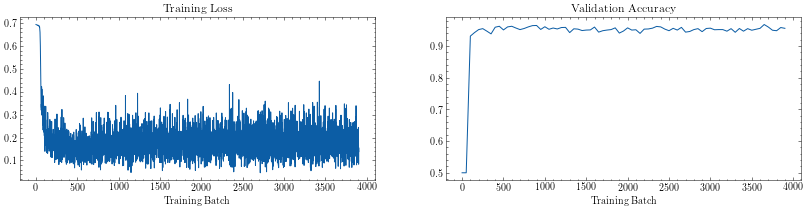

In [108]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.plot(loss_ls)
plt.xlabel('Training Batch')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
xvals = np.arange(len(spiking_acc_ls)) * VALIDATION_FREQ
plt.plot(xvals, spiking_acc_ls)
plt.xlabel('Training Batch')
plt.title('Validation Accuracy')

plt.show()

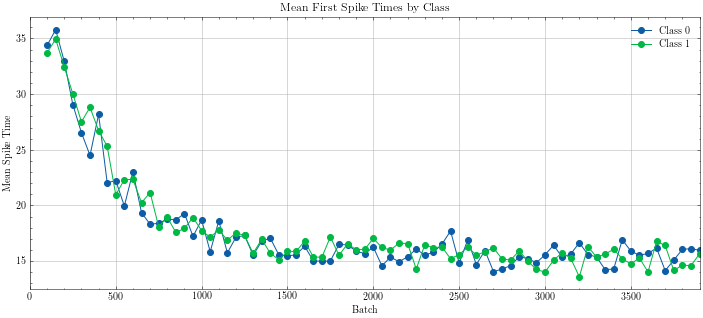

In [109]:
# plot the average first spike times by class during training (of observations that do spike)
plt.figure(figsize=(12,5))
xvals = np.arange(len(class_0_spike_times_ls)) * VALIDATION_FREQ

class_0_spike_times_arr = np.array(class_0_spike_times_ls)
mask_0 = class_0_spike_times_arr > 0
plt.xlim(0, len(xvals))
plt.plot(xvals[mask_0], class_0_spike_times_arr[mask_0], linestyle='-',
         marker='o', label='Class 0')

class_1_spike_times_arr = np.array(class_1_spike_times_ls)
mask_1 = class_1_spike_times_arr > 0
plt.xlim(0, xvals[-1])
plt.plot(xvals[mask_1], class_1_spike_times_arr[mask_1], linestyle='-',
         marker='o', label='Class 1')

plt.title('Mean First Spike Times by Class')
plt.ylabel('Mean Spike Time')
plt.xlabel('Batch')
plt.grid()
plt.legend(loc='best')
plt.show()

In [176]:
# load best model and evaluate on test set
model = LSTM(1, 1, 125)
model.load_state_dict(torch.load(PATH))
model.to(device)

def evaluate_test(TEST_SIZE=100000):
    ######################## TEST SET ########################
    model.eval()
    with torch.no_grad():
        X, y, opt_idx, std_vec = generate_ns_batch(TEST_SIZE, min_change_point=40,
                                            max_change_point=41, seq_len=40,
                                            lower=0.05, upper=0.25, margin=0.05)
        X.unsqueeze_(-1)
        out = model(X)
        out = s(out)

        # generate tensors of spikes and preds
        spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
        preds, no_spike_count = gather_spiking_preds(spikes, out)

        # spiking accuracy
        spike_acc = torch.sum(y == torch.round(preds))/y.size(0)
        # final output accuracy
        reg_acc = torch.sum(torch.round(out[:,-1].squeeze(-1)) == y)/y.size(0)
    
    stats = (reg_acc.item(), spike_acc.item(), no_spike_count)
    return stats, spikes, std_vec, X, y, preds, out

stats, spikes, std_vec, X, y, preds, out = evaluate_test(100000)
    
print('Final output accuracy:', stats[0])
print('Accuracy if evaluated on first spike:', stats[1])
print(f'(including {stats[2]} observations with no spikes)')


Final output accuracy: 0.9693599939346313
Accuracy if evaluated on first spike: 0.9636899828910828
(including 7259 observations with no spikes)


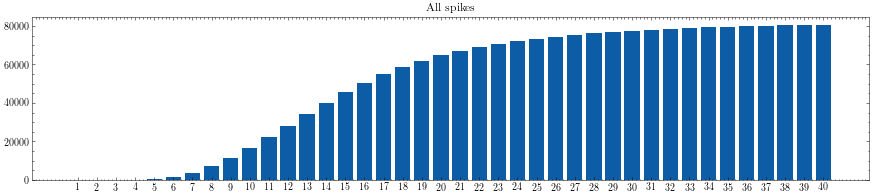

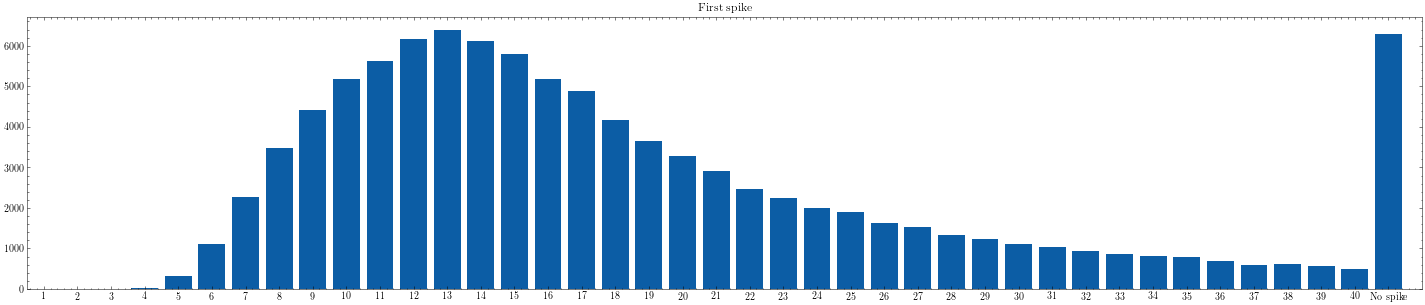

In [111]:
# plot when all spikes occur and first spike occurs across the sequence
# Note: first spike at index 1 refers to observations that did not spike
plt.figure(figsize=(15,3))
# plt.subplot(1, 2, 1)
plt.bar(x=list(range(1,41)), height=spikes.cpu().sum(axis=0))
plt.title('All spikes')
plt.xticks(list(range(1,41)))
plt.show()

# plt.subplot(1, 2, 2)
plt.figure(figsize=(25,5))
first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
values, counts = first_spike_idx.unique(return_counts=True)
heights = torch.zeros(41)
for i, v in enumerate(values):
    if i == 0:
      heights[v] = 0
    else:
      heights[v] = counts[i]
heights[-1] = counts[0]
plt.bar(x=list(range(1,42)), height=heights)
plt.title('First spike')
xticks = np.array(list(range(1,41)))
xticks = np.append(xticks, 'No spike')
plt.xlim(0.5, 42)
plt.xticks(np.arange(len(xticks)) + 1, xticks)

plt.show()

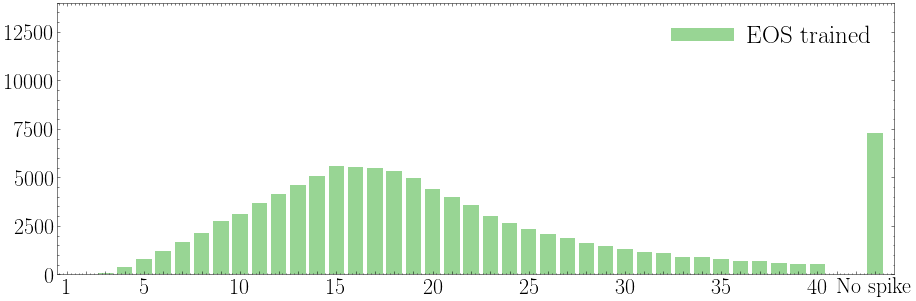

In [177]:
col = plt.cm.Greens(0*(0.6/0.4) + 0.4)
text_size = 26
tick_label_size = 22
legend_size = 25

plt.figure(figsize=(15,5))
first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
values, counts = first_spike_idx.unique(return_counts=True)
heights = torch.zeros(43)
for i, v in enumerate(values):
    if i == 0:
      heights[v] = 0
    else:
      heights[v] = counts[i]
heights[-1] = counts[0]
plt.rc('ytick',labelsize=tick_label_size)
plt.bar(x=list(range(1,44)), height=heights, color=col)
# plt.title('First spike', fontsize=text_size)
xticks = np.array(list(range(1,41)) + ['', '', 'No spike'])
xticks[1:4] = ''
xticks[5:9] = ''
xticks[10:14] = ''
xticks[15:19] = ''
xticks[20:24] = ''
xticks[25:29] = ''
xticks[30:34] = ''
xticks[35:39] = ''
plt.ylim(0,14000)
plt.xlim(0.5, 44)
plt.xticks(np.arange(len(xticks)) + 1, xticks, fontsize=tick_label_size)
legend_elements = [Line2D([0], [0], color=col, label=f'EOS trained', linewidth=13)]
plt.legend(handles=legend_elements, loc='upper right', prop={'size': legend_size})

plt.savefig('eos_long.svg', format='svg', dpi = 1200)
plt.show()

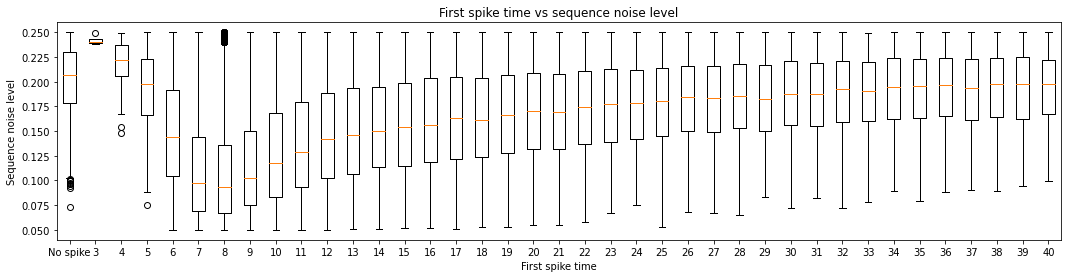

In [ ]:
# first spike time vs noise level

# grab the relevant vectors
std_vec_np = std_vec.squeeze(-1).cpu().numpy()
first_spike_idx_np = first_spike_idx.cpu().numpy()

# sort both according to spike timings
sort_idx = first_spike_idx_np.argsort()
first_spike_idx_np = first_spike_idx_np[sort_idx]
std_vec_np = std_vec_np[sort_idx]

# custom xticks
xticks = np.unique(first_spike_idx_np)
xticks = np.array(xticks, dtype=object) + 1
xticks[0] = 'No spike'

# split the noise values into buckets based on their first spike index
noise_arr = np.array(np.split(std_vec_np, np.unique(first_spike_idx_np, return_index=True)[1][1:]),
              dtype=object)

# boxplot 
plt.figure(figsize=(18,4))
plt.boxplot(noise_arr)
plt.title('First spike time vs sequence noise level')
plt.xlabel('First spike time')
plt.ylabel('Sequence noise level')
plt.xticks(np.arange(len(xticks)) + 1, xticks)

plt.show()

In [ ]:
### OPTIONAL PLOT OF NOISE VS SPIKE TIME ###

# # want to convert all noise values to categories
# # then boxplot these categories against first spike times
# noise_groups = np.split(np.sort(std_vec_np), 20)
# plt.figure(figsize=(18,4))

# noise_meds = np.array([np.median(vals) for vals in noise_groups])
# # now convert these medians to bins
# noise_bins = np.zeros(len(noise_meds)-1)
# for i in range(len(noise_meds)-1):
#   noise_bins[i] = (noise_meds[i] + noise_meds[i+1])/2
# std_vec_binned = np.digitize(std_vec_np, noise_bins)

# spike_idx = first_spike_idx_np != 0
# std_vec_binned = std_vec_binned[spike_idx]
# first_spike_idx_np = first_spike_idx_np[spike_idx]

# idx_sort = std_vec_binned.argsort()
# first_spike_idx_np = first_spike_idx_np[idx_sort]
# std_vec_binned = std_vec_binned[idx_sort]

# time_arr = np.array(np.split(first_spike_idx_np, np.unique(std_vec_binned, return_index=True)[1][1:]),
#               dtype=object)

# plt.boxplot(time_arr)
# plt.xlabel('Noise level')
# plt.ylabel('Spike time')
# plt.xticks(np.arange(len(noise_meds)) + 1, np.round(noise_meds, 2))
# plt.plot()

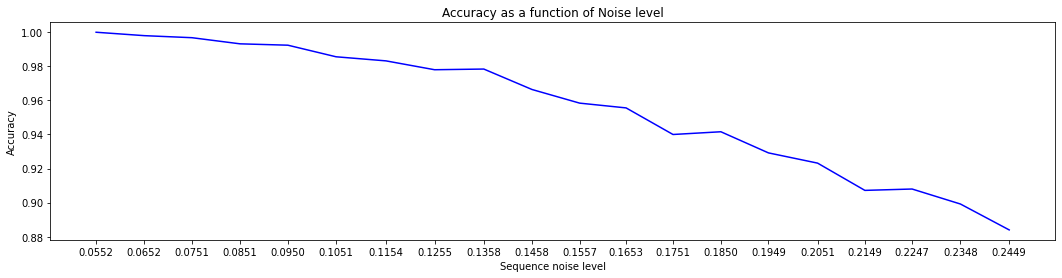

In [ ]:
# plot of noise level against accuracy 

_, spikes, std_vec, _, y, preds, _ = evaluate_test()
std_vec_np = std_vec.squeeze(-1).cpu().numpy()

# evaluate each first spike prediction
eval_np = (y == torch.round(preds)).cpu().numpy()

# sort both according to noise level
sort_idx = std_vec_np.argsort()
eval_np = eval_np[sort_idx]
std_vec_np = std_vec_np[sort_idx]

eval_bins = np.split(eval_np, 20)
noise_bins = np.split(std_vec_np, 20)

accs = np.array([np.mean(bin) for bin in eval_bins])
xticks = np.array([np.median(bin) for bin in noise_bins])

# plot accuracy of spikes
plt.figure(figsize=(18,4))
plt.plot(list(xticks), accs, color='blue')
plt.xticks(list(xticks))
plt.title('Accuracy as a function of Noise level')
plt.xlabel('Sequence noise level')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# TRAIN A BASELINE MODEL USING ONLY FINAL OUTPUT OF SEQUENCE 

baseline = LSTM(1, 1, 125)
baseline.to(device)
optimiser_baseline = torch.optim.Adam(baseline.parameters(), lr=0.0003)
criterion = torch.nn.BCELoss()
s = nn.Sigmoid()

print('################## TRAINING BASELINE ##################')
print('Training {} examples in batches of size {}'.format(NUM_TRAIN_EXAMPLES, BATCH_SIZE))
print(f'resulting in {num_batches} batches')
print('#######################################################\n')

time.sleep(0.2)
for i in tqdm(range(num_batches)):
    ######################## TRAIN A BATCH ########################
    # generate some training data 
    X, y, _, _ = generate_ns_batch(batch_size=BATCH_SIZE, min_change_point=40,
                                   max_change_point=41, seq_len=40, lower=0.05,
                                   upper=0.25, margin=0.05)
    X.unsqueeze_(-1)
    
    # learn through network
    baseline.train()
    optimiser_baseline.zero_grad()
    out = baseline(X)
    out = s(out)
        
    preds = out[:, -1, 0]
    
    loss = criterion(preds, y)
    loss_ls.append(loss.item())
    loss.backward()
    optimiser_baseline.step()
optimiser_baseline.zero_grad()

  0%|          | 0/15625 [00:00<?, ?it/s]

################## TRAINING BASELINE ##################
Training 2000000 examples in batches of size 128
resulting in 15625 batches
#######################################################



100%|██████████| 15625/15625 [01:04<00:00, 242.84it/s]


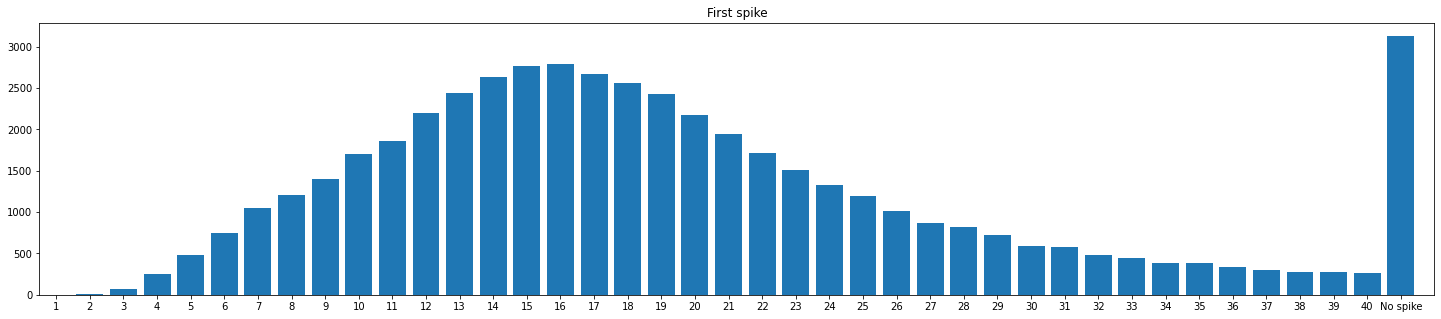

In [ ]:
# plot first spike times of baseline

plt.figure(figsize=(25,5))

# just use this function to generate some data
_, spikes, _, X, y, preds, out = evaluate_test()

torch.cuda.empty_cache()  # clear cache for these big batches
with torch.no_grad():
  out = baseline(X)
  out = s(out) 
  spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)


first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
values, counts = first_spike_idx.unique(return_counts=True)
heights = torch.zeros(41)
for i, v in enumerate(values):
    if i == 0:
      heights[v] = 0
    else:
      heights[v] = counts[i]
heights[-1] = counts[0]
plt.bar(x=list(range(1,42)), height=heights)
plt.title('First spike')
xticks = np.array(list(range(1,41)))
xticks = np.append(xticks, 'No spike')
plt.xlim(0.5, 42)
plt.xticks(np.arange(len(xticks)) + 1, xticks)

plt.show()


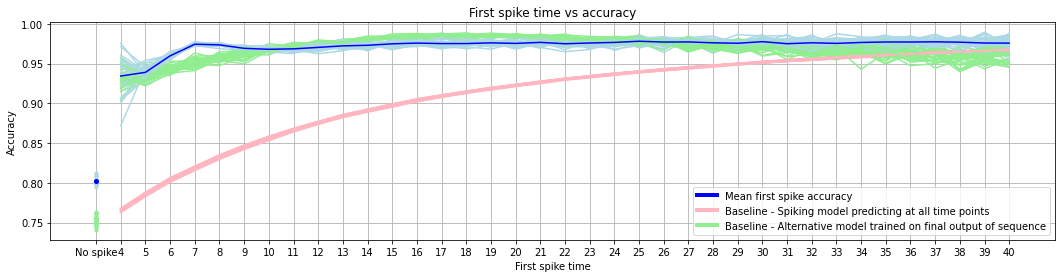

In [ ]:
# plot accuracy against first spike time for a bunch of test sets

# import warnings
# warnings.filterwarnings(action='ignore', message='Mean of empty slice')
# warnings.filterwarnings(action='ignore', message='invalid value encountered in double_scalars')
plt.figure(figsize=(18,4))
all_accs = []
test_set_size = 100000
for _ in range(30):
  # evaluate test set and extract first spike
  torch.cuda.empty_cache()  # clear cache for these big batches
  _, spikes, _, X, y, preds, out = evaluate_test(test_set_size)
  first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
  first_spike_idx_np = first_spike_idx.cpu().numpy()

  # evaluate each first spike prediction
  eval_np = (y == torch.round(preds)).cpu().numpy()

  # sort both according to spike timings
  sort_idx = first_spike_idx_np.argsort()
  first_spike_idx_np = first_spike_idx_np[sort_idx]
  eval_np = eval_np[sort_idx]

  # split the bool evaluations into buckets based on their first spike index
  eval_bins = np.split(eval_np, np.unique(first_spike_idx_np, return_index=True)[1][1:])

  # deal with small prob of unequal bins between runs (kinda hacky)
  if len(eval_bins) < 38:
    eval_bins = eval_bins[:1] + [[]] + eval_bins[1:]
  if len(eval_bins) > 38:
    eval_bins = eval_bins[:1] + eval_bins[2:]

  # # evaluate accuracy within each bin
  eval_bins = np.array(eval_bins, dtype=object)
  accs = np.array([np.mean(bin) for bin in eval_bins])

  # plot accuracy of spikes
  plt.plot([0], [accs[0]], marker='o', markersize=3, color="lightblue")
  plt.plot(list(range(1,38)), accs[1:], color='lightblue')
  all_accs.append(accs)

  # # plot baseline accuracy using means at each time step
  # baseline_accs = []
  # _, spikes, _, X, y, preds = evaluate_test()
  # seq_len = X.shape[1]
  # test_size = X.shape[0]
  # for i in range(3, seq_len):
  #     X_sub = X[:, :i+1, :]
  #     baseline_preds = (X_sub.mean(axis=1) > 0) * 1
  #     baseline_acc = torch.sum(baseline_preds.squeeze(-1) == y)/test_size
  #     baseline_accs.append(baseline_acc.item())
  # plt.plot(list(range(1,38)), baseline_accs, color='lightpink')

  # plot baseline based on rank coding trained lstm predicting at all timesteps
  all_preds = torch.round(out).squeeze(-1)
  all_ys = y.unsqueeze(-1).repeat(1, 40)
  baseline_accs_2 = (all_preds == all_ys).sum(dim=0)/test_set_size
  plt.plot(list(range(1,38)), baseline_accs_2[3:].cpu(), color='lightpink')

  # plot baseline trained using only the final output in the sequence
  with torch.no_grad():
    #   torch.cuda.empty_cache()
    #   out = baseline(X)
    #   out = s(out) 

    #   spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
    #   first_spike_idx = torch.argmax(spikes, dim=1, keepdim=True)
    #   # replace no spike with last idx for prediction
    #   first_spike_idx[first_spike_idx == 0] = 39
    #   preds = torch.gather(out, 1, first_spike_idx)  
    #   preds = preds.squeeze(-1).squeeze(-1)

    # # torch.cuda.empty_cache()
    # # out = baseline(X)
    # # out = s(out)  
    #   all_preds3 = torch.round(preds)
    #   baseline_accs_3 = (all_preds3 == all_ys).sum(dim=0)/test_set_size
    #   plt.plot(list(range(1,38)), baseline_accs_3[3:].cpu(), color='lightgreen')
      # evaluate test set and extract first spike
    
    # evaluate baseline in same way as spiking trained model
    torch.cuda.empty_cache()  # clear cache for these big batches
    # _, spikes, _, X, y, preds, out = evaluate_test(test_set_size)
    out = baseline(X)
    out = s(out) 
    spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
    first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
    first_spike_idx_np = first_spike_idx.cpu().numpy()

    preds, _ = gather_spiking_preds(spikes, out)

    # evaluate each first spike prediction
    eval_np = (y == torch.round(preds)).cpu().numpy()

    # sort both according to spike timings
    sort_idx = first_spike_idx_np.argsort()
    first_spike_idx_np = first_spike_idx_np[sort_idx]
    eval_np = eval_np[sort_idx]

    # split the bool evaluations into buckets based on their first spike index
    eval_bins = np.split(eval_np, np.unique(first_spike_idx_np, return_index=True)[1][1:])

    # deal with small prob of unequal bins between runs (kinda hacky)
    if len(eval_bins) < 38:
      eval_bins = eval_bins[:1] + [[]] + eval_bins[1:]
    if len(eval_bins) > 39:
      eval_bins = eval_bins[:1] + eval_bins[2:]
    if len(eval_bins) > 38:
      eval_bins = eval_bins[:1] + eval_bins[2:]

    # # evaluate accuracy within each bin
    eval_bins = np.array(eval_bins, dtype=object)
    accs = np.array([np.mean(bin) for bin in eval_bins])

    # plot accuracy of spikes
    plt.plot([0], [accs[0]], marker='o', markersize=3, color="lightgreen")
    plt.plot(list(range(1,38)), accs[1:], color='lightgreen')

# also plot the mean across all runs in dark blue
# xticks = np.unique(first_spike_idx_np)
# xticks = np.array(xticks, dtype=object) + 1
xticks = np.arange(38) + 3
xticks = np.array(xticks, dtype=object)
xticks[0] = 'No spike'

mean_accs = np.nanmean(all_accs, axis=0)
plt.plot([0], [mean_accs[0]], marker='o', markersize=4, color="blue")
plt.plot(list(range(1,38)), mean_accs[1:], color='blue')
plt.xticks(np.arange(len(xticks)), xticks)
plt.title('First spike time vs accuracy')
plt.xlabel('First spike time')
plt.ylabel('Accuracy')
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='lightpink', lw=4),
                Line2D([0], [0], color='lightgreen', lw=4)]
plt.legend(custom_lines, ['Mean first spike accuracy', 'Baseline - Spiking model predicting at all time points',
                          'Baseline - Alternative model trained on final output of sequence'])
plt.grid()
plt.show()